# Numerical Analysis Project
Team: 아프지마

Member

* 20181628 성창훈
* 20181635 신명철

written by 성창훈, 신명철

# Google Colab

<U>AutoKeras는 GPU를 지원하므로</U> 원활한 학습을 위해서 Google Colab의 GPU를 이용해서 학습한다.

Google Colab에서는 Tesla K80과 Tesla T4 두 종류의 GPU를 제공한다.

이 노트에서는 K80보다 성능이 더 좋은 Tesla T4를 이용한다.

GPU를 이용하는 경우에는 CUDA와 CuDNN의 버전이 중요하다.

아래 표 우측 상단에서 CUDA의 버전이 11.2임을 확인할 수 있다.

In [1]:
!nvidia-smi

Mon May 24 18:11:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


## Packages

대다수의 Web-Based notebook 서비스들(Google Colab, Kaggle, Paperspace...)은 docker를 이용해 일관된 환경을 제공한다.

환경의 업데이트는 패키지의 업데이트보다 보수적으로 이루어지므로 보통 버전이 낮다.

이때 일부 최신 패키지는 높은 버전의 pip 버전을 요하므로, 반드시 패키지 관리 도구를 최신 버전으로 업데이트하여 사용한다.

업데이트 후에는 kernel을 다시 시작한다. (초기화가 아님에 유의한다)

In [1]:
!pip install --upgrade pip
!pip install --upgrade setuptools

런타임 다시 시작

여기서 mxnet을 CUDA의 버전에 맞게 설치해야 한다.

메뉴얼에서 CUDA 버전이 10.0인 경우 mxnet_cu100을 설치하라고 하였으므로, 위에서 살펴본 CUDA 버전에 알맞은 패키지는 mxnet_cu110이다. (mxnet_cu112는 없음)

In [2]:
# Here we assume CUDA 10.1 is installed.  You should change the number
# according to your own CUDA version (e.g. mxnet_cu100 for CUDA 10.0).
!python3 -m pip install --upgrade "mxnet_cu110<2.0.0"

신속한 패치 적용을 위해 pre-release 버전을 설치했다.

In [3]:
!pip install --pre autogluon

# AutoGluon

AutoGluon이라는 이름이 조금 생소하지만, 이 오픈소스의 repo는 AWS Labs에 속해있다.

성능도 성능이지만, 무엇보다 가장 사용하기 편한 패키지로 기억된다.

AutoGluon은 ImagePredictor를 제공하여 이미지에 전문화된 모델을 자동으로 탐색하고(NAS), 하이퍼파라메터를 최적화한다(HPO).

In [4]:
import autogluon.core as ag
from autogluon.vision import ImagePredictor

# Data Loading
Kaggle의 Leaf Rice Disease Dataset을 이용한다.

다른 모든 AutoML 패키지와 구분되는 기능을 제공한다.

바로 디렉토리로부터 자동으로 train과 test 데이터셋을 만들어내는 함수를 제공한다.

심지어 배치 사이즈와 이미지 사이즈도 알아서 맞춰준다.

프로젝트를 진행하면서 .npz 파일로 이미지셋을 로드하는 방식을 채택해서 한결 일처리가 수월해졌지만, 그 전까지는 AutoGluon의 from_folders() 메소드는 사막의 오아시스같은 존재였다.

구글 드라이브에 3:1 비율로 구서한 학습 데이터와 검증 데이터를 압축해 업로드했고, 이를 노트북에서 불러와 이용했다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip ./drive/MyDrive/archive_60_20.zip -d .

Archive:  ./drive/MyDrive/archive_60_20.zip
   creating: ./data/
   creating: ./data/test/
   creating: ./data/test/blast/
  inflating: ./data/test/blast/IMG_0682.jpg  
  inflating: ./data/test/blast/IMG_0684.jpg  
  inflating: ./data/test/blast/IMG_0687.jpg  
  inflating: ./data/test/blast/IMG_0691.jpg  
  inflating: ./data/test/blast/IMG_0692.jpg  
  inflating: ./data/test/blast/IMG_0694.jpg  
  inflating: ./data/test/blast/IMG_0695.jpg  
  inflating: ./data/test/blast/IMG_0698.jpg  
  inflating: ./data/test/blast/IMG_0701.jpg  
  inflating: ./data/test/blast/IMG_0704.jpg  
  inflating: ./data/test/blast/IMG_0705.jpg  
  inflating: ./data/test/blast/IMG_0707.jpg  
  inflating: ./data/test/blast/IMG_0708.jpg  
  inflating: ./data/test/blast/IMG_0711.jpg  
  inflating: ./data/test/blast/IMG_0713.jpg  
  inflating: ./data/test/blast/IMG_0716.jpg  
  inflating: ./data/test/blast/IMG_0717.jpg  
  inflating: ./data/test/blast/IMG_0718.jpg  
  inflating: ./data/test/blast/IMG_0720.jpg  
  i

In [5]:
# %cd /content
train_dataset, _, test_dataset = ImagePredictor.Dataset.from_folders('/content/data')
print(train_dataset)
print(test_dataset)

                                       image  label
0     /content/data/train/blast/IMG_0448.jpg      0
1     /content/data/train/blast/IMG_0535.jpg      0
2     /content/data/train/blast/IMG_0536.jpg      0
3     /content/data/train/blast/IMG_0541.jpg      0
4     /content/data/train/blast/IMG_0543.jpg      0
..                                       ...    ...
175  /content/data/train/tungro/IMG_0886.jpg      2
176  /content/data/train/tungro/IMG_0887.jpg      2
177  /content/data/train/tungro/IMG_0888.jpg      2
178  /content/data/train/tungro/IMG_0889.jpg      2
179  /content/data/train/tungro/IMG_0890.jpg      2

[180 rows x 2 columns]
                                     image  label
0    /content/data/test/blast/IMG_0682.jpg      0
1    /content/data/test/blast/IMG_0684.jpg      0
2    /content/data/test/blast/IMG_0687.jpg      0
3    /content/data/test/blast/IMG_0691.jpg      0
4    /content/data/test/blast/IMG_0692.jpg      0
5    /content/data/test/blast/IMG_0694.jpg      0
6 

# Build a classifier and Fit

AutoGluon이 Imgage classification에 적합한 모델을 탐색한다.

코드가 간단한 것이 AutoML의 큰 장점인데, 모델 설계와 학습을 단 두 줄에 끝냈다.

시간과 자원을 고려해 최대 탐색 시간은 30분으로 제한했다.

기본적으로 fit() 메소드에서 verbose를 지원한다.

실시간으로 얼마나 어떻게 학습했는지, 하이퍼파라메터가 얼마나 달라지는지 확인할 수 있었다.

INFO:root:Reset labels to [0, 1, 2]
INFO:gluoncv.auto.tasks.image_classification:Randomly split train_data into train[170]/validation[10] splits.
INFO:gluoncv.auto.tasks.image_classification:Starting HPO experiments


INFO:ImageClassificationEstimator:modified configs(<old> != <new>): {
INFO:ImageClassificationEstimator:root.img_cls.model   resnet50_v1 != resnet50_v1b
INFO:ImageClassificationEstimator:root.valid.num_workers 4 != 0
INFO:ImageClassificationEstimator:root.valid.batch_size 128 != 16
INFO:ImageClassificationEstimator:root.train.lr        0.1 != 0.01
INFO:ImageClassificationEstimator:root.train.rec_val_idx ~/.mxnet/datasets/imagenet/rec/val.idx != auto
INFO:ImageClassificationEstimator:root.train.num_workers 4 != 0
INFO:ImageClassificationEstimator:root.train.batch_size 128 != 16
INFO:ImageClassificationEstimator:root.train.rec_train_idx ~/.mxnet/datasets/imagenet/rec/train.idx != auto
INFO:ImageClassificationEstimator:root.train.data_dir  ~/.mxnet/datasets/imagenet != auto
INFO:ImageClassificationEstimator:root.train.epochs    10 != 20
INFO:ImageClassificationEstimator:root.train.early_stop_patience -1 != 10
INFO:ImageClassificationEstimator:root.train.rec_val   ~/.mxnet/datasets/imagene

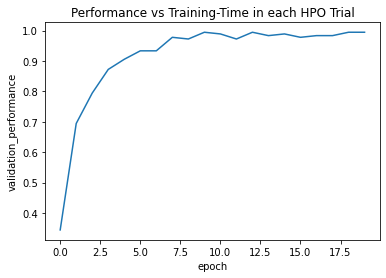

INFO:gluoncv.auto.tasks.image_classification:Finished, total runtime is 759.32 s
INFO:gluoncv.auto.tasks.image_classification:{ 'best_config': { 'estimator': <class 'gluoncv.auto.estimators.image_classification.image_classification.ImageClassificationEstimator'>,
                   'gpus': [0],
                   'img_cls': { 'batch_norm': False,
                                'last_gamma': False,
                                'model': 'resnet50_v1b',
                                'use_gn': False,
                                'use_pretrained': True,
                                'use_se': False},
                   'train': { 'batch_size': 16,
                              'crop_ratio': 0.875,
                              'data_dir': 'auto',
                              'dtype': 'float32',
                              'early_stop_baseline': -inf,
                              'early_stop_max_value': inf,
                              'early_stop_min_delta': 0.001,
        

In [46]:
predictor = ImagePredictor(path='/content/checkpoint')
# since the original dataset does not provide validation split, the `fit` function splits it randomly with 90/10 ratio
predictor.fit(train_dataset, time_limit=1800, hyperparameters={'epochs': 20}, hyperparameter_tune_kwargs={'num_trials':3})  # you can trust the default config, we reduce the # epoch to save some build time

이때 AutoGluon은 MNIST나 다른 데이터셋에 비하면 상대적으로 적은 양의 데이터 양을 가지고도 매우 빠르게 높은 정확성을 가진 모델을 찾아냈다. 심지어 data augmentation도 하지 않았다.

눈여겨볼 점은 train accuracy보다 validation accuracy가 더 높다는 것이다.

보통 학습하면서 train 데이터에 overfit이 되기 마련인데, 놀랍게도 학습하지 않은 내용을 더 잘 맞춘 것이다!

In [47]:
fit_result = predictor.fit_summary()
print('Top-1 train acc: %.3f, val acc: %.3f' %(fit_result['train_acc'], fit_result['valid_acc']))

Top-1 train acc: 0.966, val acc: 0.983


# Get accuracy of the final model

가장 좋은 성능을 보여준 모델로 테스트를 진행한다.

30분의 제한을 걸었음에도 약 13분만에 학습이 종료되었으며, test_accuracy 또한 train accuracy보다 높은 98.3%를 달성했다.

시간 비용과 데이터의 양, 정확성을 고려했을 때 AutoGluon은 가장 우수한 성능을 보였다.

In [48]:
test_acc, _ = predictor.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)

Top-1 test acc: 0.983
